<a href="https://colab.research.google.com/github/kr-pushpam/Data-Mining-Assignment/blob/main/Data_Mining_Assignment_01_Solution_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Question 2: Use the scikit-learn python package to build a least squares linear regression model to predict the house price in the attached dataset.**

  # **(a) What are the predictors that have a relationship with the house price response variable? What does the coefficients of the predictors suggest?**
  
  # **(b) Is there evidence of non-linear association between any of the predictors and  the response? Use interaction terms and transformations of the predictors to try and improve your prediction accuracy?**


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


# Create Dataframe for further analysis
os.chdir('/content/drive/My Drive/Colab Notebooks/Data_Mining_Assignment')

file_path = 'Philadelphia_Crime_Rate_noNA.csv'
df_copy = pd.read_csv(file_path)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = df_copy.copy() # also create a copy of the dataframe

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Section 1. Understand the Data**

In [ ]:
import pandas as pd
import numpy as np

def KnowYourData(df, target_variable = 'HousePrice'):
    """
    Function to display basic information about the dataset, check for missing values,
    provide basic statistics, identify the target variable and potential predictors,
    and check for outliers in numeric columns.

    Parameters:
    df (pd.DataFrame): The dataset.
    target_variable (str): The target variable for the analysis.

    Returns:
    None
    """
    # Display the first few rows to understand the structure of the dataset
    print("First few rows of the dataset:")
    print(df.head())

    # Get a summary of the dataset (column names, data types, non-null values)
    print("\nSummary of the dataset:")
    df.info()

    # Check for missing values
    print("\nChecking for missing values:")
    missing_values = df.isnull().sum()
    print(missing_values)

    # Describe the dataset for basic statistics (mean, std, min, max)
    print("\nBasic statistical overview of the dataset:")
    print(df.describe())

    # Select numeric columns for further analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for numeric columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Identifying outliers for numeric columns
    outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()

    print("\nNumber of outliers in each numeric column:")
    print(outliers)

    # Display columns with significant outliers
    significant_outliers = outliers[outliers > 0]
    if len(significant_outliers) > 0:
        print("\nColumns with significant outliers:")
        print(significant_outliers)
    else:
        print("\nNo significant outliers found in the numeric columns.")

    # Check for negative values in numeric columns
    print("\nChecking for negative values in numeric columns:")
    negative_values = df[numeric_cols].apply(lambda x: (x < 0).sum())
    print(negative_values)

    # Identify maximum negative value in columns that contain negative values
    max_negative_values = df[numeric_cols].apply(lambda x: x[x < 0].min() if (x < 0).any() else None)
    print("\nMaximum negative value in each numeric column:")
    print(max_negative_values.dropna())

    if negative_values.sum() > 0:
        print("\nColumns with negative values and their maximum negative value:")
        for col in numeric_cols:
            if negative_values[col] > 0:
                print(f"{col}: Maximum negative value = {max_negative_values[col]}")
    else:
        print("\nNo negative values found in the numeric columns.")


In [ ]:
KnowYourData(df_copy)

First few rows of the dataset:
   HousePrice  CrimeRate  MilesPhila  PopChg        Name    County
0      140463       29.7        10.0    -1.0    Abington  Montgome
1      113033       24.1        18.0     4.0      Ambler  Montgome
2      124186       19.5        25.0     8.0       Aston  Delaware
3      110490       49.4        25.0     2.7    Bensalem     Bucks
4       79124       54.1        19.0     3.9  Bristol B.     Bucks

Summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HousePrice  99 non-null     int64  
 1   CrimeRate   99 non-null     float64
 2   MilesPhila  99 non-null     float64
 3   PopChg      99 non-null     float64
 4   Name        99 non-null     object 
 5   County      99 non-null     object 
dtypes: float64(3), int64(1), object(2)
memory usage: 4.8+ KB

Checking for missing values:
HousePrice    0
Crim

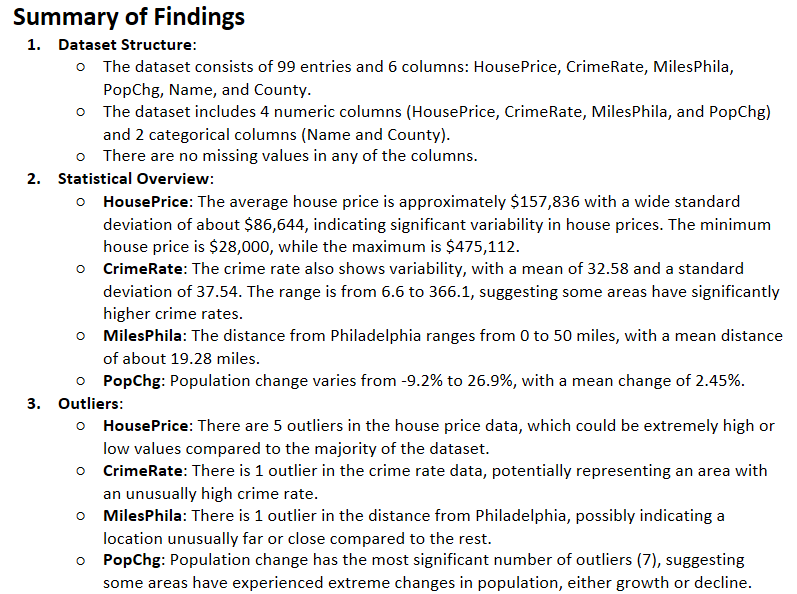

In [ ]:
df.head()

,HousePrice,CrimeRate,MilesPhila,PopChg,Name,County
0,140463,29.7,10.0,-1.0,Abington,Montgome
1,113033,24.1,18.0,4.0,Ambler,Montgome
2,124186,19.5,25.0,8.0,Aston,Delaware
3,110490,49.4,25.0,2.7,Bensalem,Bucks
4,79124,54.1,19.0,3.9,Bristol B.,Bucks


In [ ]:
from scipy import stats

# Handling Negative Values in PopChg usind stand shift
df['PopChg'] = df['PopChg'] + abs(df['PopChg'].min()) + 1  # Shift all values to make them positive

In [ ]:
df.head()

,HousePrice,CrimeRate,MilesPhila,PopChg,Name,County
0,140463,29.7,10.0,9.2,Abington,Montgome
1,113033,24.1,18.0,14.2,Ambler,Montgome
2,124186,19.5,25.0,18.2,Aston,Delaware
3,110490,49.4,25.0,12.9,Bensalem,Bucks
4,79124,54.1,19.0,14.1,Bristol B.,Bucks


In [ ]:
print("Checking for negative values after shifting `PopChg`:")
print((df['PopChg'] < 0).sum())  # This should return 0

Checking for negative values after shifting `PopChg`:
0


In [ ]:
#Normalize the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['HousePrice', 'CrimeRate', 'MilesPhila', 'PopChg']] = scaler.fit_transform(df[['HousePrice', 'CrimeRate', 'MilesPhila', 'PopChg']])


In [ ]:
df.head()

,HousePrice,CrimeRate,MilesPhila,PopChg,Name,County
0,0.251532,0.064256,0.20,0.227147,Abington,Montgome
1,0.190183,0.048679,0.36,0.365651,Ambler,Montgome
2,0.215127,0.035883,0.50,0.476454,Aston,Delaware
3,0.184495,0.119054,0.50,0.329640,Bensalem,Bucks
4,0.114343,0.132128,0.38,0.362881,Bristol B.,Bucks


In [ ]:
##outliers Treatment is pendi

# Log is not working
# removing outiers also not working - new outliers are generated once exisitng is removed


In [ ]:
KnowYourData(df)

First few rows of the dataset:
   HousePrice  CrimeRate  MilesPhila    PopChg        Name    County
0    0.251532   0.064256        0.20  0.227147    Abington  Montgome
1    0.190183   0.048679        0.36  0.365651      Ambler  Montgome
2    0.215127   0.035883        0.50  0.476454       Aston  Delaware
3    0.184495   0.119054        0.50  0.329640    Bensalem     Bucks
4    0.114343   0.132128        0.38  0.362881  Bristol B.     Bucks

Summary of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   HousePrice  85 non-null     float64
 1   CrimeRate   85 non-null     float64
 2   MilesPhila  85 non-null     float64
 3   PopChg      85 non-null     float64
 4   Name        85 non-null     object 
 5   County      85 non-null     object 
dtypes: float64(4), object(2)
memory usage: 4.1+ KB

Checking for missing values:
HousePrice    0
Cr

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Assuming the dataset has been cleaned and is stored in df
# Prepare the predictors (X) and response variable (y)
X = df[['CrimeRate', 'MilesPhila', 'PopChg']]  # Add other predictors if needed
y = df['HousePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Print the coefficients of the predictors
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("\nCoefficients of the predictors:")
print(coefficients)


Mean Squared Error: 0.011176573692001139
R-squared: 0.4300467149790639

Coefficients of the predictors:
            Coefficient
CrimeRate     -1.310839
MilesPhila     0.123478
PopChg         0.064454


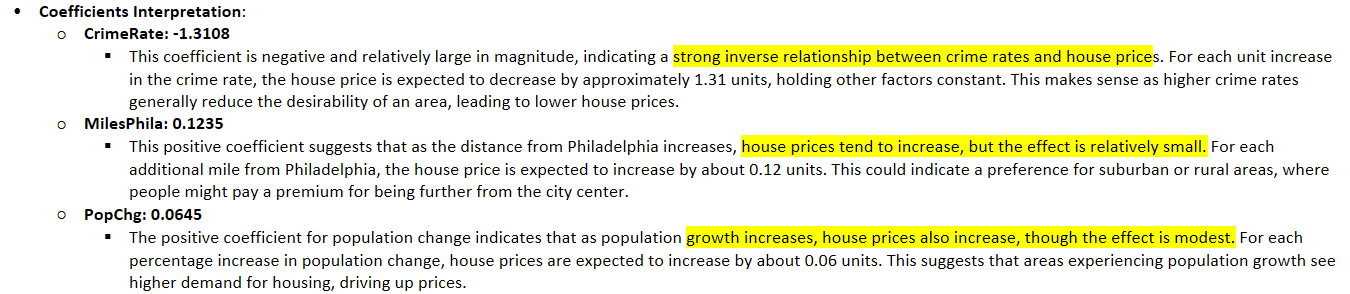


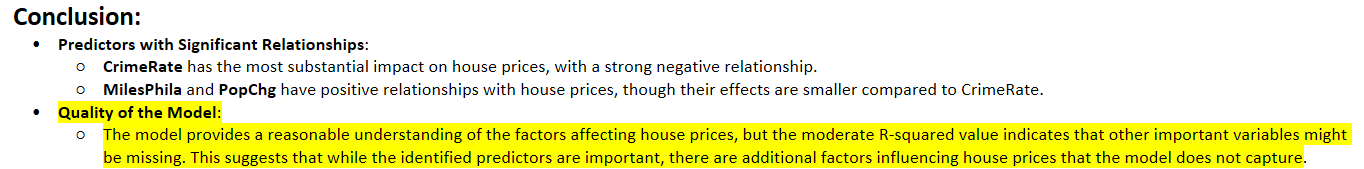

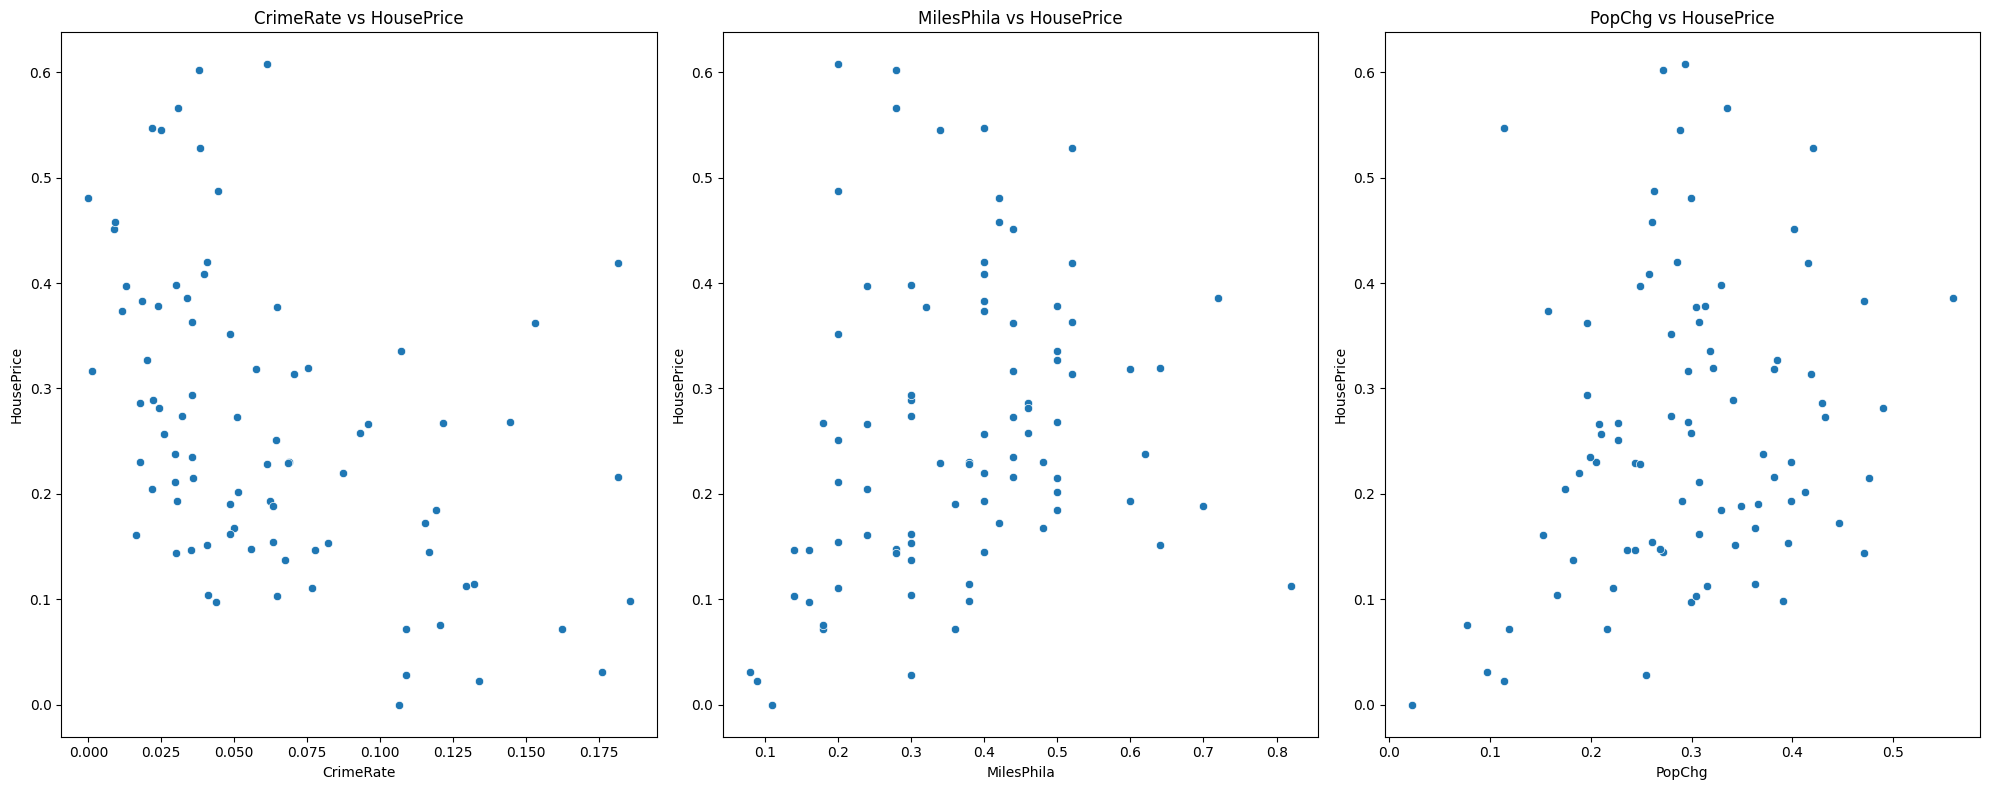

In [ ]:
## Non-Linear Relationship

import seaborn as sns
import matplotlib.pyplot as plt

# Visualize relationships between predictors and the response variable
plt.figure(figsize=(20, 8))
predictors = ['CrimeRate', 'MilesPhila', 'PopChg']
for i, predictor in enumerate(predictors, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(x=df[predictor], y=df['HousePrice'])
    plt.title(f'{predictor} vs HousePrice')
plt.tight_layout()
plt.show()


In [ ]:
#Step 2: Apply Non-Linear Transformations

df['CrimeRate_squared'] = df['CrimeRate'] ** 2
df['MilesPhila_squared'] = df['MilesPhila'] ** 2
df['PopChg_squared'] = df['PopChg'] ** 2

df['CrimeRate_cube'] = df['CrimeRate'] ** 3
df['MilesPhila_cube'] = df['MilesPhila'] ** 3
df['PopChg_cube'] = df['PopChg'] ** 3

df['CrimeRate_log'] = np.log1p(df['CrimeRate'])
df['MilesPhila_log'] = np.log1p(df['MilesPhila'])
df['PopChg_log'] = np.log1p(df['PopChg'])

# df['CrimeRate_sqrt'] = np.sqrt(df['CrimeRate'])
# df['MilesPhila_sqrt'] = np.sqrt(df['MilesPhila'])
# df['PopChg_sqrt'] = np.sqrt(df['PopChg'])

df['CrimeRate_MilesPhila_interaction'] = df['CrimeRate'] * df['MilesPhila']
df['CrimeRate_PopChg_interaction'] = df['CrimeRate'] * df['PopChg']
df['MilesPhila_PopChg_interaction'] = df['MilesPhila'] * df['PopChg']


In [ ]:
# Define predictors including the transformed and interaction terms
X_transformed = df[['CrimeRate', 'MilesPhila', 'PopChg',
                    'CrimeRate_squared', 'MilesPhila_squared', 'PopChg_squared',
                    'CrimeRate_log', 'MilesPhila_log', 'PopChg_log',
                    'CrimeRate_MilesPhila_interaction',
                    'CrimeRate_PopChg_interaction',
                    'MilesPhila_PopChg_interaction']]

y = df['HousePrice']

# Split the data into training and testing sets
X_train_transformed, X_test_transformed, y_train_transformed, y_test_transformed = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model_transformed = LinearRegression()
model_transformed.fit(X_train_transformed, y_train_transformed)

# Make predictions
y_pred_transformed = model_transformed.predict(X_test_transformed)

# Evaluate the model
mse_transformed = mean_squared_error(y_test_transformed, y_pred_transformed)
r2_transformed = r2_score(y_test_transformed, y_pred_transformed)

print(f"Mean Squared Error after transformations: {mse_transformed}")
print(f"R-squared after transformations: {r2_transformed}")

# Print the coefficients of the predictors
coefficients_transformed = pd.DataFrame(model_transformed.coef_, X_transformed.columns, columns=['Coefficient'])
print("\nCoefficients of the predictors after transformations:")
print(coefficients_transformed)


Mean Squared Error after transformations: 0.0075684129421478286
R-squared after transformations: 0.6140461345627495

Coefficients of the predictors after transformations:
                                  Coefficient
CrimeRate                         -346.752702
MilesPhila                         -13.015480
PopChg                             -14.612227
CrimeRate_squared                  158.160865
MilesPhila_squared                   2.730267
PopChg_squared                       2.816112
CrimeRate_log                      345.633144
MilesPhila_log                      14.686246
PopChg_log                          16.230637
CrimeRate_MilesPhila_interaction     0.234577
CrimeRate_PopChg_interaction        -1.046431
MilesPhila_PopChg_interaction        1.138145


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assume df is your DataFrame with predictors and response variable
# Select the predictors and response variable
X = df[['CrimeRate', 'MilesPhila', 'PopChg']]
y = df['HousePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize a list to store performance metrics
performance_metrics = []

# Loop through polynomial degrees from 2 to 5
for degree in range(0, 6):
    # Create polynomial features for the current degree
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Create and train the linear regression model on the polynomial features
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test_poly)

    # Calculate the Mean Squared Error (MSE) and R-squared (R²)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append the results to the performance_metrics list
    performance_metrics.append({
        'Degree': degree,
        'MSE': mse,
        'R-squared': r2
    })

# Convert the performance metrics list to a DataFrame
performance_metrics_df = pd.DataFrame(performance_metrics)

# Display the performance metrics for each polynomial degree
print(performance_metrics_df)


   Degree        MSE    R-squared
0       0   0.019960    -0.017856
1       1   0.011177     0.430047
2       2   0.006615     0.662671
3       3   0.004453     0.772904
4       4   0.073172    -2.731436
5       5  47.173035 -2404.605437


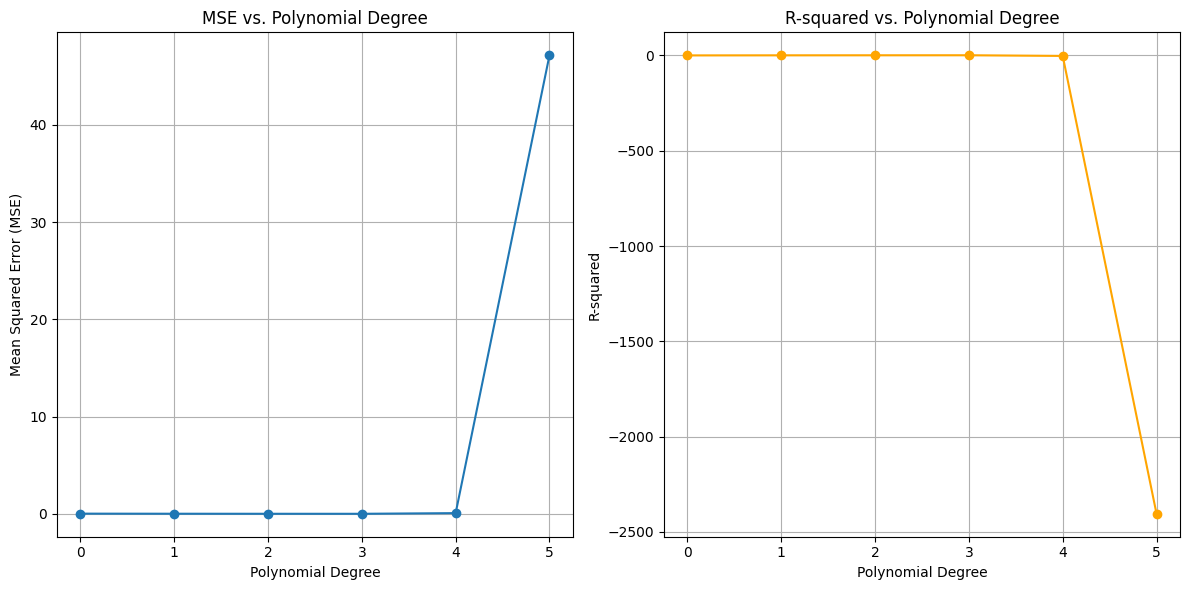

In [ ]:
# Plotting the performance metrics
plt.figure(figsize=(12, 6))

# Plot Mean Squared Error (MSE) vs. Degree
plt.subplot(1, 2, 1)
plt.plot(performance_metrics_df['Degree'], performance_metrics_df['MSE'], marker='o')
plt.title('MSE vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True)

# Plot R-squared vs. Degree
plt.subplot(1, 2, 2)
plt.plot(performance_metrics_df['Degree'], performance_metrics_df['R-squared'], marker='o', color='orange')
plt.title('R-squared vs. Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R-squared')
plt.grid(True)

plt.tight_layout()
plt.show()

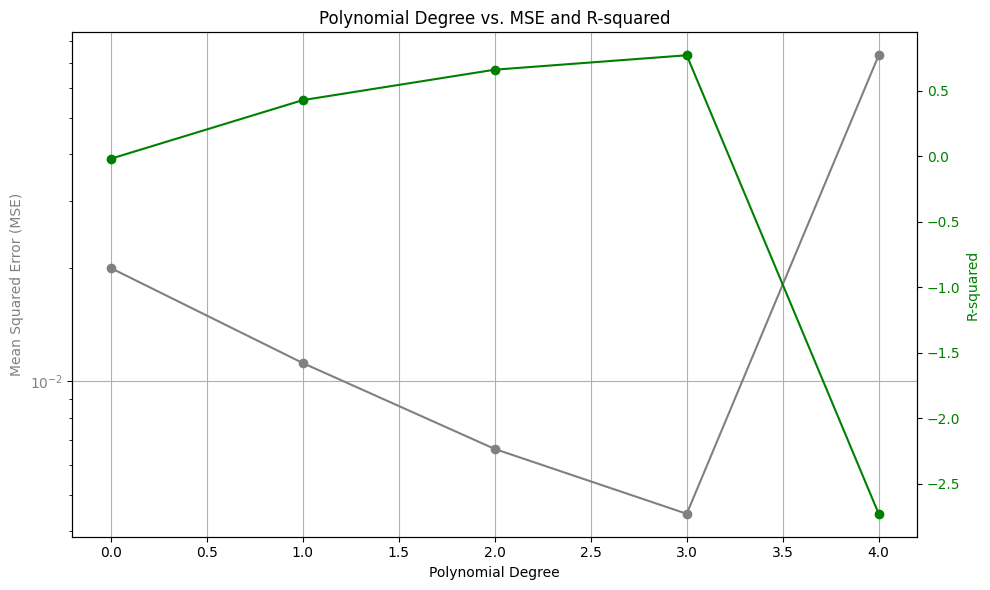

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from your provided output
performance_metrics_df = pd.DataFrame({
    'Degree': [0, 1, 2, 3, 4],
    'MSE': [0.019960, 0.011177, 0.006615, 0.004453, 0.073172],
    'R-squared': [-0.017856, 0.430047, 0.662671, 0.772904, -2.731436]
})

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the MSE on the primary y-axis
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('Mean Squared Error (MSE)', color='grey')
ax1.plot(performance_metrics_df['Degree'], performance_metrics_df['MSE'], marker='o', color='grey')
ax1.set_yscale('log')  # Use a logarithmic scale for MSE
ax1.tick_params(axis='y', labelcolor='grey')
ax1.grid(True)

# Create a secondary y-axis for the R-squared values
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('R-squared', color='green')
ax2.plot(performance_metrics_df['Degree'], performance_metrics_df['R-squared'], marker='o', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Add a title and show the plot
plt.title('Polynomial Degree vs. MSE and R-squared')
fig.tight_layout()  # Ensure the plot does not overlap
plt.show()


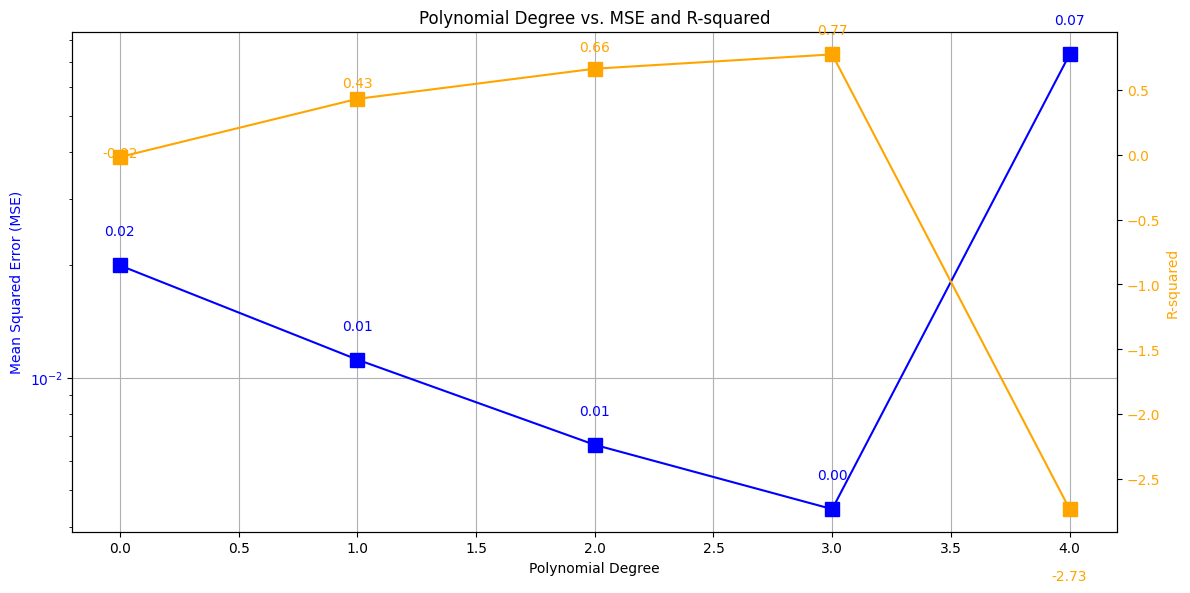

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example data from your provided output
performance_metrics_df = pd.DataFrame({
    'Degree': [0, 1, 2, 3, 4],
    'MSE': [0.019960, 0.011177, 0.006615, 0.004453, 0.073172],
    'R-squared': [-0.017856, 0.430047, 0.662671, 0.772904, -2.731436]
})

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the MSE on the primary y-axis
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('Mean Squared Error (MSE)', color='blue')
ax1.plot(performance_metrics_df['Degree'], performance_metrics_df['MSE'], marker='s', markersize=10, color='blue', label='MSE')
ax1.set_yscale('log')  # Use a logarithmic scale for MSE
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Annotate the MSE values on the plot with adjusted position
for i in range(len(performance_metrics_df)):
    ax1.text(performance_metrics_df['Degree'][i], performance_metrics_df['MSE'][i] * 1.2,  # Adjusting position
             f'{performance_metrics_df["MSE"][i]:.2f}', color='blue', fontsize=10, ha='center')

# Create a secondary y-axis for the R-squared values
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('R-squared', color='orange')
ax2.plot(performance_metrics_df['Degree'], performance_metrics_df['R-squared'], marker='s', markersize=10, color='orange', label='R-squared')
ax2.tick_params(axis='y', labelcolor='orange')

# Annotate the R-squared values on the plot with adjusted position
for i in range(len(performance_metrics_df)):
    ax2.text(performance_metrics_df['Degree'][i], performance_metrics_df['R-squared'][i] * 1.2,  # Adjusting position
             f'{performance_metrics_df["R-squared"][i]:.2f}', color='orange', fontsize=10, ha='center')

# Add a title and show the plot
plt.title('Polynomial Degree vs. MSE and R-squared')
fig.tight_layout()  # Ensure the plot does not overlap
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Assume df is your DataFrame with predictors and response variable
X = df[['CrimeRate', 'MilesPhila', 'PopChg']]
y = df['HousePrice']

# Define the linear regression model
model = LinearRegression()

# Perform cross-validation
# Here, we use 10-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

# Output the results
print(f"Cross-Validated Mean Squared Error: {-cv_mean:.5f} ± {cv_std:.5f}")


Cross-Validated Mean Squared Error: 0.01642 ± 0.00730


In [ ]:
# Perform cross-validation for polynomial regression models with varying degrees
degrees = [1, 2, 3]  # You can test more degrees if desired

for degree in degrees:
    # Create a pipeline that first transforms the data with PolynomialFeatures, then applies LinearRegression
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

    # Perform 10-fold cross-validation
    cv_scores = cross_val_score(model, X, y, cv=10, scoring='neg_mean_squared_error')

    # Calculate the mean and standard deviation of the cross-validation scores
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)

    # Output the results
    print(f"Degree {degree}: Cross-Validated MSE: {-cv_mean:.5f} ± {cv_std:.5f}")


Degree 1: Cross-Validated MSE: 0.01642 ± 0.00730
Degree 2: Cross-Validated MSE: 0.01774 ± 0.01127
Degree 3: Cross-Validated MSE: 0.04584 ± 0.08365


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def normalize_and_log_transform(df, columns_to_transform):
    """
    Normalize the data and then apply log transformation to specified columns.

    Parameters:
    df (pd.DataFrame): The dataset.
    columns_to_transform (list): List of column names to normalize and transform.

    Returns:
    pd.DataFrame: The dataset with normalized and log-transformed columns.
    """
    # # Initialize the MinMaxScaler
    # scaler = MinMaxScaler()

    # # Normalize the columns
    df_normalized = df.copy()
    # df_normalized[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

    # # Apply log transformation after normalization
    # for column in columns_to_transform:
    #     df_normalized[column] = np.log1p(df_normalized[column])

    # Apply log transformation after normalization
    for column in columns_to_transform:
        # Add a small constant to avoid log(0) issues
        df_normalized[column] = np.log1p(df_normalized[column] + 1e-9)

    return df_normalized

# Normalize and apply log transformation
df_transformed = normalize_and_log_transform(df_copy, columns_to_transform)

In [ ]:
KnowYourData(df_transformed, target_variable)

In [ ]:
# Plot the distributions before and after transformation for comparison
def plot_distributions_comparison(df_original, df_transformed, columns):
    plt.figure(figsize=(16, 16))
    for i, column in enumerate(columns):
        plt.figure(figsize=(20, 8))
        # Original Distribution
        plt.subplot(len(columns), 2, 2*i + 1)
        sns.histplot(df_original[column], kde=True)
        plt.title(f'Original Distribution of {column}')

        # Log Transformed Distribution
        plt.subplot(len(columns), 2, 2*i + 2)
        sns.histplot(df_transformed[column], kde=True)
        plt.title(f'Log Transformed Distribution of {column}')

    plt.tight_layout()
    plt.show()

# Plot the distributions before and after log transformation
plot_distributions_comparison(df, df_log_transformed, columns_with_outliers)


In [ ]:
import pandas as pd
import numpy as np

def KnowYourData(df, target_variable='HousePrice'):
    """
    Function to display basic information about the dataset, check for missing values,
    provide basic statistics, identify the target variable and potential predictors,
    check for outliers in numeric columns, and identify columns with negative values.

    Parameters:
    df (pd.DataFrame): The dataset.
    target_variable (str): The target variable for the analysis.

    Returns:
    None
    """
    # Display the first few rows to understand the structure of the dataset
    print("First few rows of the dataset:")
    print(df.head())

    # Get a summary of the dataset (column names, data types, non-null values)
    print("\nSummary of the dataset:")
    df.info()

    # Check for missing values
    print("\nChecking for missing values:")
    missing_values = df.isnull().sum()
    print(missing_values)

    # Describe the dataset for basic statistics (mean, std, min, max)
    print("\nBasic statistical overview of the dataset:")
    print(df.describe())

    # Identify the target variable and potential predictors
    predictors = df.drop(columns=[target_variable]).columns.tolist()

    print(f"\nTarget Variable: {target_variable}")
    print(f"Potential Predictors: {predictors}")

    # Select numeric columns for further analysis
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for numeric columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Identifying outliers for numeric columns
    outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).sum()

    print("\nNumber of outliers in each numeric column:")
    print(outliers)

    # Display columns with significant outliers
    significant_outliers = outliers[outliers > 0]
    if len(significant_outliers) > 0:
        print("\nColumns with significant outliers:")
        print(significant_outliers)
    else:
        print("\nNo significant outliers found in the numeric columns.")

    # Check for negative values in numeric columns
    print("\nChecking for negative values in numeric columns:")
    negative_values = df[numeric_cols].apply(lambda x: (x < 0).sum())
    print(negative_values)

    # Identify maximum negative value in columns that contain negative values
    max_negative_values = df[numeric_cols].apply(lambda x: x[x < 0].min() if (x < 0).any() else None)
    print("\nMaximum negative value in each numeric column:")
    print(max_negative_values.dropna())

    if negative_values.sum() > 0:
        print("\nColumns with negative values and their maximum negative value:")
        for col in numeric_cols:
            if negative_values[col] > 0:
                print(f"{col}: Maximum negative value = {max_negative_values[col]}")
    else:
        print("\nNo negative values found in the numeric columns.")


In [ ]:
KnowYourData(df)